In [1]:
import scanpy as sc
import pandas as pd
import scvi
import numpy as np
import pandas as pd
import seaborn as sns

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata_integrate_raw = sc.read_h5ad('adata_integrate_raw.h5ad')
scvi.model.SCVI.setup_anndata(adata_integrate_raw, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
## save model after training finish
dir_path = '/data2/ZenNa/DFU_Project/Code/Model' 
model = scvi.model.SCVI.load(dir_path, adata_integrate_raw)


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File /data2/ZenNa/DFU_Project/Code/Model/model.pt already downloaded                                      


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatte

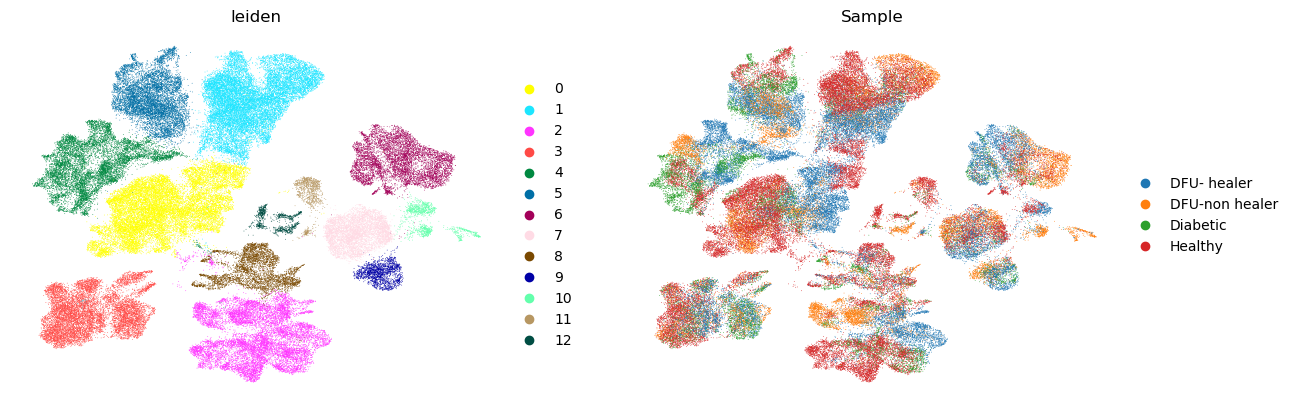

In [7]:
adata_integrate_raw.obsm['X_scVI'] = model.get_latent_representation()
adata_integrate_raw.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata_integrate_raw, use_rep = 'X_scVI')
sc.tl.umap(adata_integrate_raw)
sc.tl.leiden(adata_integrate_raw, resolution = 0.2)
sc.pl.umap(adata_integrate_raw, color = ['leiden', 'Sample'], frameon = False)

In [8]:
sc.tl.rank_genes_groups(adata_integrate_raw, 'leiden')

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


KeyError: 'CD68'

In [14]:
markers = sc.get.rank_genes_groups_df(adata_integrate_raw, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group     names      scores  logfoldchanges     pvals  pvals_adj
0         1     NR2F2  158.698166        3.407403  0.000000   0.000000
1         1     TAGLN  158.409409        3.556880  0.000000   0.000000
2         1      TPM2  157.151260        3.331546  0.000000   0.000000
3         1  C11orf96  152.925079        3.419885  0.000000   0.000000
4         1     ACTA2  150.894516        3.905878  0.000000   0.000000
...     ...       ...         ...             ...       ...        ...
17114     2    RNF212    2.117161        0.696020  0.034246   0.042374
17122     2    TVP23C    2.100758        0.515412  0.035662   0.044057
17126     2    ATAD3C    2.095119        1.289398  0.036160   0.044650
17129     2   PABPC1L    2.089980        0.921710  0.036620   0.045198
17157     2     USP21    2.053490        0.731113  0.040025   0.049171

[5199 rows x 6 columns]

In [15]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|████████████████████████████████████| 13/13 [02:25<00:00, 11.16s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
SFRP2       0.9844        0.0156      4.144761  0.001961  0.000324   
COMP        0.9832        0.0168      4.069433  0.002423  0.000258   
SCARA5      0.9828        0.0172      4.045496  0.000239  0.000028   
MMP2        0.9826        0.0174      4.033731  0.002472  0.000401   
SFRP4       0.9818        0.0182      3.987965  0.000765  0.000107   
...            ...           ...           ...       ...       ...   
C12orf43    0.5124        0.4876      0.049610  0.000019  0.000018   
CCDC174     0.5044        0.4956      0.017600  0.000034  0.000032   
UPF3B       0.5038        0.4962      0.015200  0.000037  0.000036   
USP39       0.4574        0.5426     -0.170814  0.000018  0.000017   
ZC3H15      0.4486        0.5514     -0.206329  0.000124  0.000111   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
SFRP2              0.0   0.25  5.007544    5.429996  3.110004  ...  16.201790   
COMP               0.0   0.25  5.332883    5.709220  3.081891  ...  23.950245   
SCARA5             0.0   0.25  4.303159    4.462861  2.418630  ...   1.413850   
MMP2               0.0   0.25  4.451988    4.769374  2.635338  ...  22.423820   
SFRP4              0.0   0.25  4.464484    4.641024  3.128954  ...  10.600702   
...                ...    ...       ...         ...       ...  ...        ...   
C12orf43           0.0   0.25  0.131635    0.070264  0.447625  ...   0.051962   
CCDC174            0.0   0.25  0.084252    0.049490  0.442873  ...   0.110286   
UPF3B              0.0   0.25  0.089616    0.075838  0.398645  ...   0.136798   
USP39              0.0   0.25  0.158688    0.139530  0.347295  ...   0.089077   
ZC3H15             0.0   0.25  0.173158    0.157356  0.319000  ...   0.463416   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
SFRP2      1.501566               0.710617               0.129936   
COMP       1.565243               0.600902               0.133128   
SCARA5     0.083101               0.414015               0.036570   
MMP2       2.236580               0.908571               0.247365   
SFRP4      1.012127               0.368481               0.081584   
...             ...                    ...                    ...   
C12orf43   0.111983               0.046660               0.097802   
CCDC174    0.198912               0.098621               0.165772   
UPF3B      0.218812               0.116649               0.176047   
USP39      0.114366               0.078473               0.101988   
ZC3H15     0.801534               0.332980               0.448541   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
SFRP2                17.776974              2.353835            True   
COMP                 24.954567              2.596217            True   
SCARA5                1.859579              0.124147            True   
MMP2                 21.963455              3.442848            True   
SFRP4                 7.383317              1.195548            True   
...                        ...                   ...             ...   
C12orf43              0.122309              0.152424           False   
CCDC174               0.266423              0.287543           False   
UPF3B                 0.332285              0.318966           False   
USP39                 0.191058              0.152934           False   
ZC3H15                1.149392              1.074442           False   

          comparison  group1 group2  
SFRP2      0 vs Rest       0   Rest  
COMP       0 vs Rest       0   Rest  
SCARA5     0 vs Rest       0   Rest  
MMP2       0 vs Rest       0   Rest  
SFRP4      0 vs Rest       0   Rest  
...              ...     ...    ...  
C12orf43  12 vs Rest      12   Rest  
CCDC174   12 vs Rest      12   Rest  
UPF3B     12 vs Rest      12   Rest  
USP39     12 vs Rest      12   Rest  
ZC3H15    12 vs Rest      12   Rest  

[154388 rows x 22 columns]

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


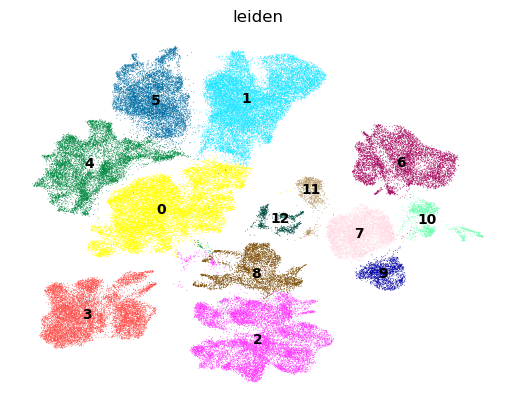

In [16]:
sc.pl.umap(adata_integrate_raw, color = ['leiden'], frameon = False, legend_loc = "on data")

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


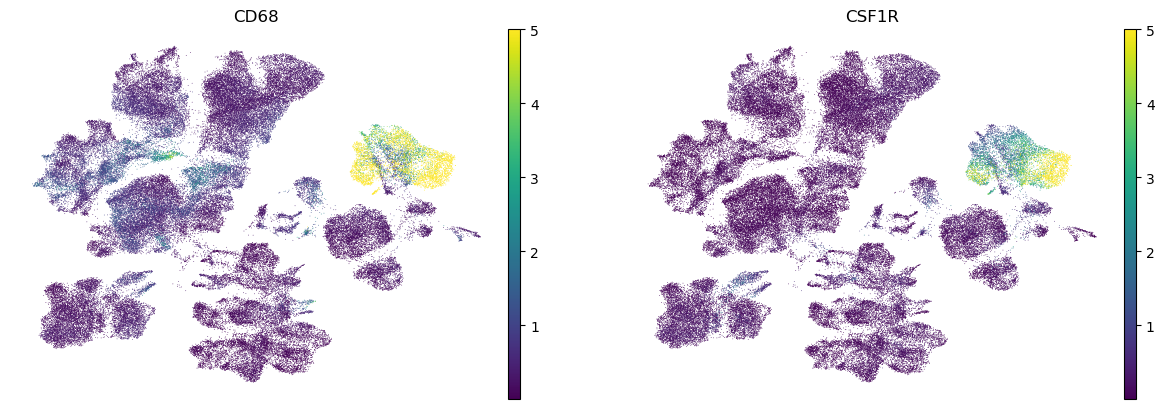

In [17]:
sc.pl.umap(adata_integrate_raw, color = ['CD68', 'CSF1R'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M2 macrophage


In [18]:
# Assuming cluster 1 is M1 and cluster 2 is M2
sc.tl.rank_genes_groups(adata_integrate_raw, 'leiden', method='wilcoxon', groups=['1', '2'])

# Get the top M1 and M2 marker genes
markers_M1 = adata_integrate_raw.uns['rank_genes_groups']['CD68']['1']
markers_M2 = adata_integrate_raw.uns['rank_genes_groups']['CD86', 'IL1B', 'IL6']['2']

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


KeyError: 'CD68'

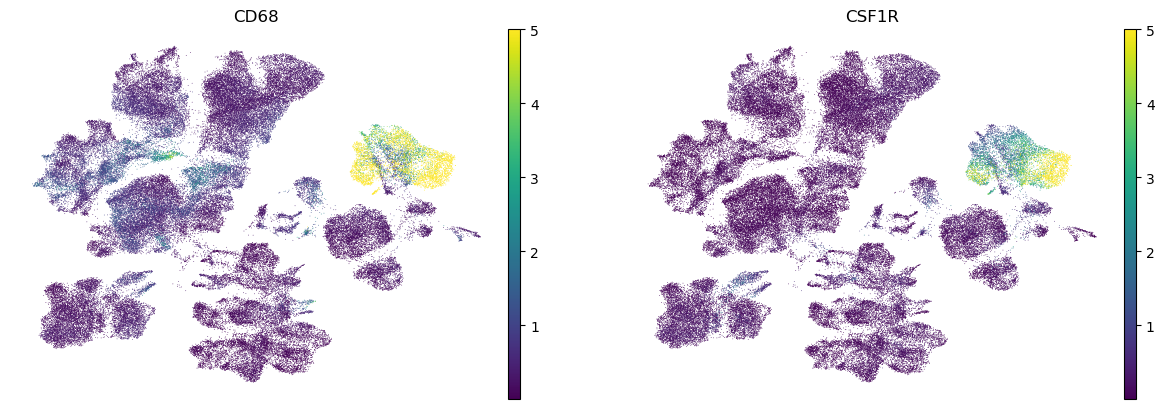

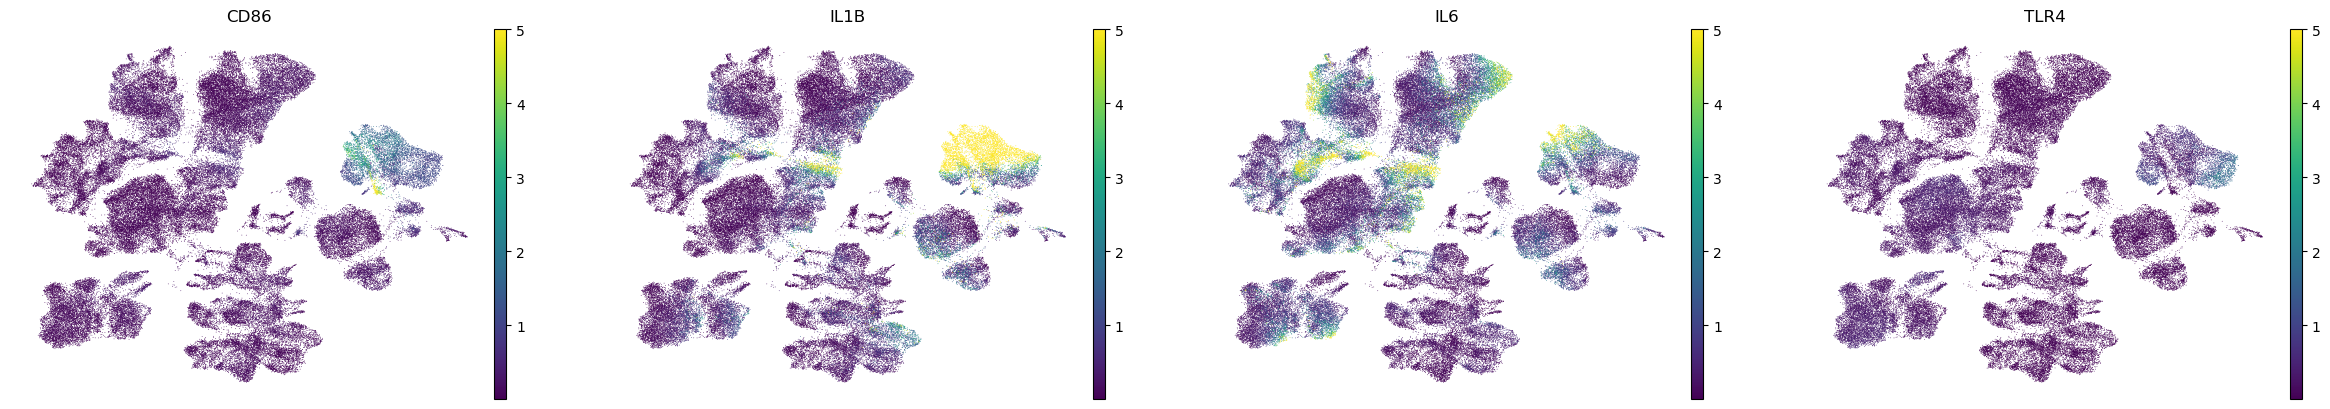

In [20]:
sc.pl.umap(adata_integrate_raw, color = ['CD68', 'CSF1R'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M2 macrophage-6
sc.pl.umap(adata_integrate_raw, color = ['CD86', 'IL1B', 'IL6','TLR4'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M1 macrophage



In [153]:
plt.show()

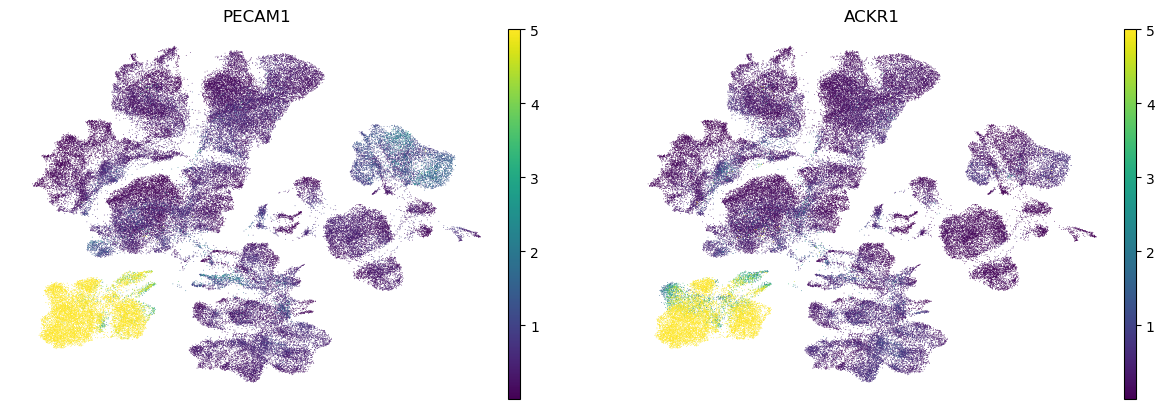

In [21]:
sc.pl.umap(adata_integrate_raw, color = ['PECAM1', 'ACKR1'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Vascular epithelial-3


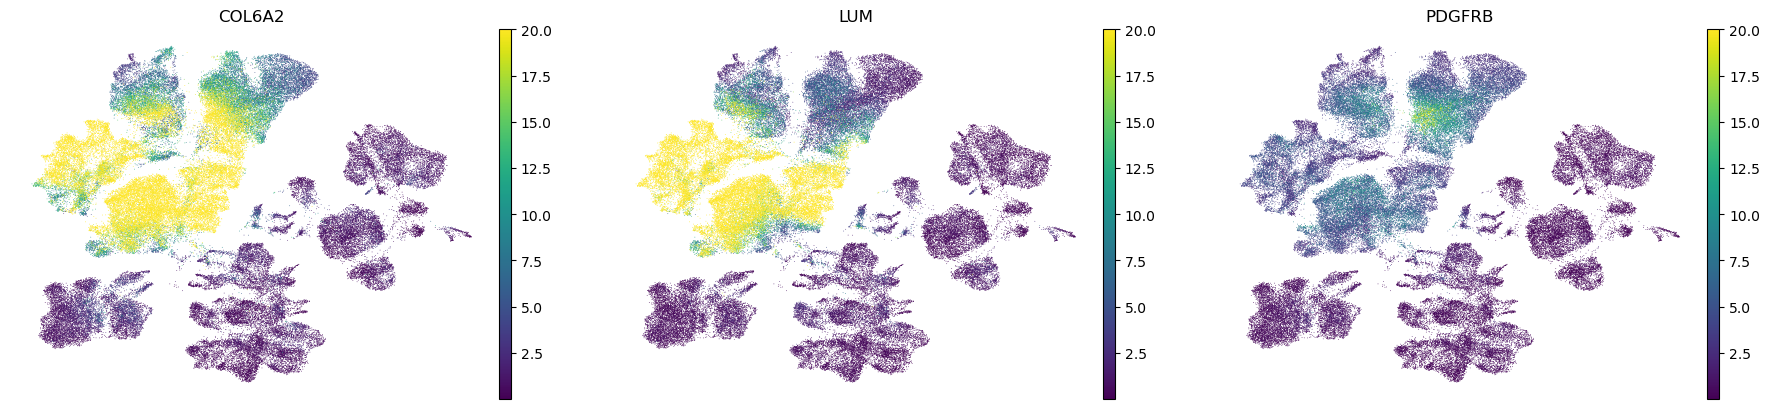

In [41]:
sc.pl.umap(adata_integrate_raw, color = ['COL6A2', 'LUM','PDGFRB'], frameon = False, layer = 'scvi_normalized', vmax = 20)  #Fibroblast 0 4


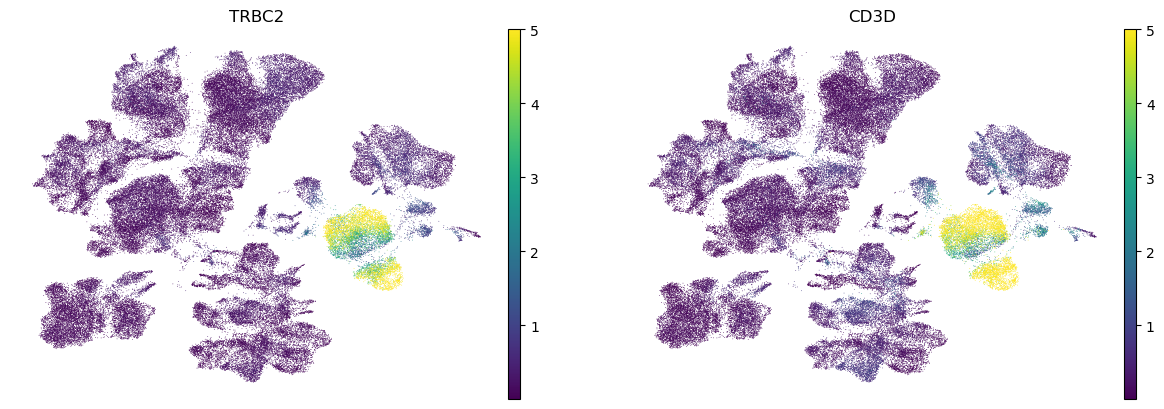

9

In [37]:
sc.pl.umap(adata_integrate_raw, color = ['TRBC2', 'CD3D'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Tcell 7-
9

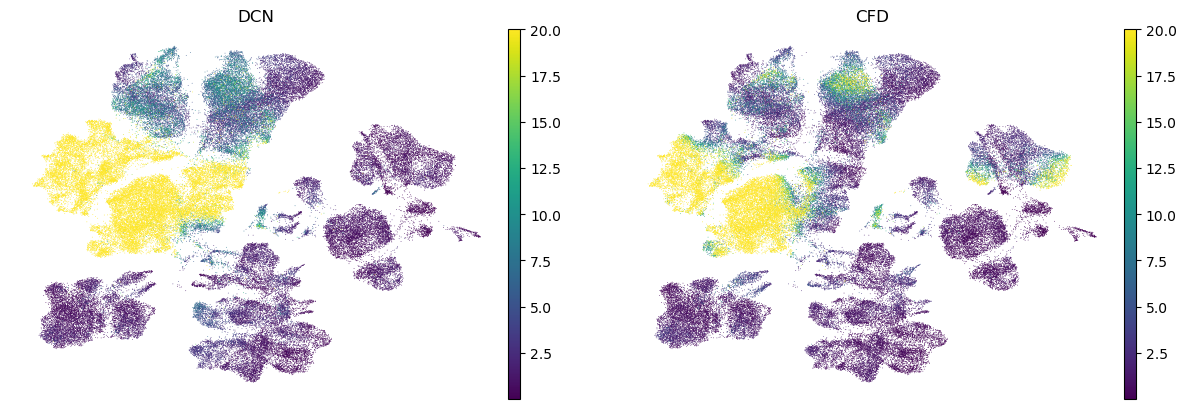

In [34]:
sc.pl.umap(adata_integrate_raw, color = ['DCN','CFD'], frameon = False, layer = 'scvi_normalized', vmax = 20) #Fibrobast

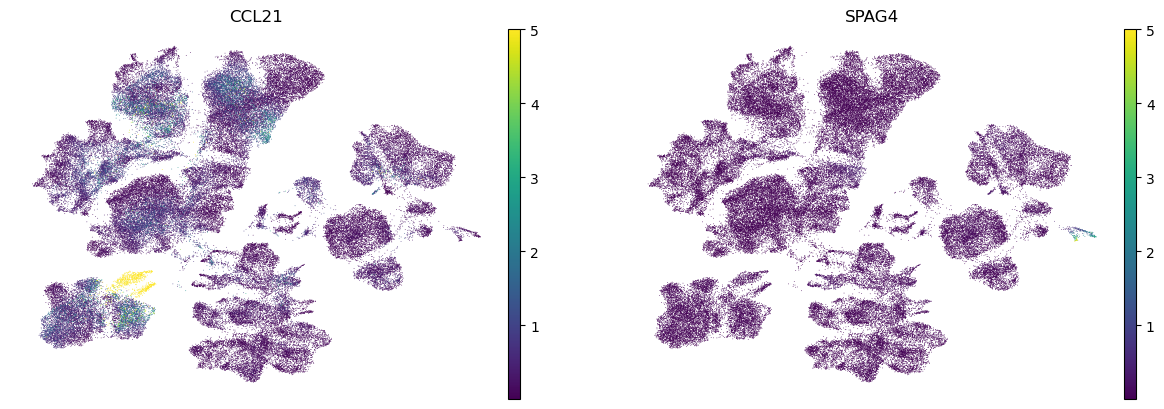

In [25]:
sc.pl.umap(adata_integrate_raw, color = ['CCL21','SPAG4'], frameon = False, layer = 'scvi_normalized', vmax = 5) #LymphEndo& Plasma


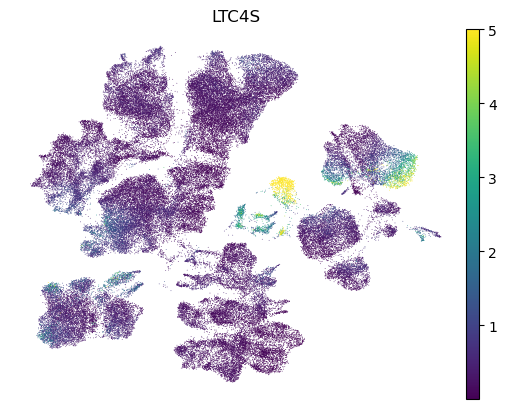

In [26]:
sc.pl.umap(adata_integrate_raw, color = ['LTC4S'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Mastcell 11


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


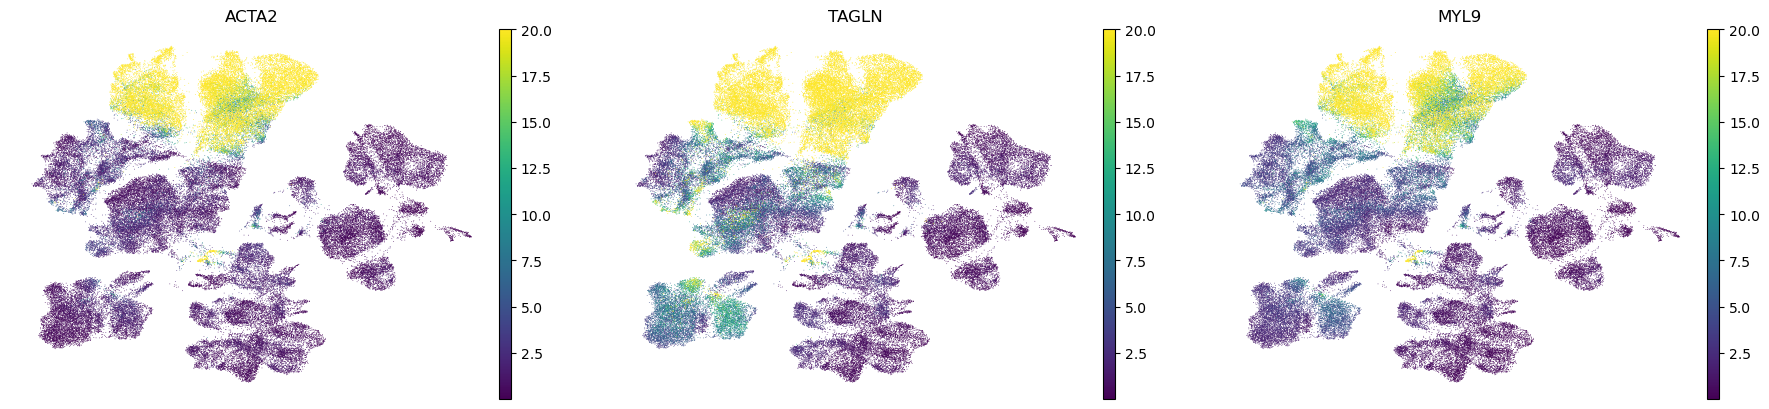

In [155]:
sc.pl.umap(adata_integrate_raw, color = ['ACTA2','TAGLN','MYL9'], frameon = False, layer = 'scvi_normalized', vmax = 20) #SMC 1,5


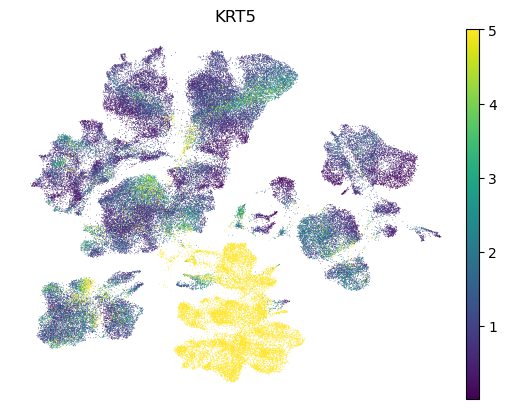

In [28]:
sc.pl.umap(adata_integrate_raw, color = ['KRT5'], frameon = False, layer = 'scvi_normalized', vmax = 5) #BasalKera 2,8


In [42]:
markers_scvi[markers_scvi.group1 == '10']

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
IGKC      0.9960        0.0040      5.517450  2.506730e-02  0.000140   
AK4       0.9952        0.0048      5.334326  5.930941e-07  0.000021   
PTGIS     0.9950        0.0050      5.293303  3.476256e-07  0.000044   
THBS4     0.9950        0.0050      5.293303  1.921665e-07  0.000057   
FST       0.9948        0.0052      5.253881  1.661827e-06  0.000048   
...          ...           ...           ...           ...       ...   
SSU72     0.5752        0.4248      0.303099  8.220299e-05  0.000087   
MRGBP     0.5750        0.4250      0.302281  1.190198e-05  0.000014   
ATG12     0.5698        0.4302      0.281035  5.295798e-05  0.000058   
ZC3H15    0.5616        0.4384      0.247658  9.600429e-05  0.000112   
NSMCE2    0.5014        0.4986      0.005600  2.186984e-05  0.000025   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...    raw_mean1  \
IGKC             0.0   0.25  6.845974    6.439651  2.920945  ...  1023.479736   
AK4              0.0   0.25 -5.122324   -5.359817  1.643618  ...     0.003213   
PTGIS            0.0   0.25 -7.130158   -7.284864  2.941392  ...     0.001606   
THBS4            0.0   0.25 -7.515418   -7.623726  3.199871  ...     0.000803   
FST              0.0   0.25 -5.130919   -5.080205  2.180707  ...     0.002410   
...              ...    ...       ...         ...       ...  ...          ...   
SSU72            0.0   0.25 -0.071615   -0.047653  0.607123  ...     0.351003   
MRGBP            0.0   0.25 -0.243703   -0.166718  0.599967  ...     0.055422   
ATG12            0.0   0.25 -0.178930   -0.088950  0.639503  ...     0.205623   
ZC3H15           0.0   0.25 -0.263861   -0.186707  0.581327  ...     0.441766   
NSMCE2           0.0   0.25 -0.200131   -0.135866  0.525105  ...     0.086747   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
IGKC     0.140228               0.750201               0.057809   
AK4      0.122110               0.003213               0.095483   
PTGIS    0.241192               0.001606               0.092609   
THBS4    0.189855               0.000803               0.044539   
FST      0.197597               0.002410               0.097237   
...           ...                    ...                    ...   
SSU72    0.681111               0.281928               0.405389   
MRGBP    0.101842               0.054618               0.092477   
ATG12    0.378392               0.179920               0.277366   
ZC3H15   0.803001               0.318876               0.449117   
NSMCE2   0.174741               0.082731               0.150649   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
IGKC              676.709412              0.271636            True   
AK4                 0.004803              0.147309            True   
PTGIS               0.004476              0.269308            True   
THBS4               0.001535              0.228003            True   
FST                 0.007809              0.282252            True   
...                      ...                   ...             ...   
SSU72               0.814938              0.887167           False   
MRGBP               0.118756              0.136927           False   
ATG12               0.507801              0.538617           False   
ZC3H15              1.000398              1.076232           False   
NSMCE2              0.219219              0.237678           False   

        comparison  group1 group2  
IGKC    10 vs Rest      10   Rest  
AK4     10 vs Rest      10   Rest  
PTGIS   10 vs Rest      10   Rest  
THBS4   10 vs Rest      10   Rest  
FST     10 vs Rest      10   Rest  
...            ...     ...    ...  
SSU72   10 vs Rest      10   Rest  
MRGBP   10 vs Rest      10   Rest  
ATG12   10 vs Rest      10   Rest  
ZC3H15  10 vs Rest      10   Rest  
NSMCE2  10 vs Rest      10   Rest  

[11876 rows x 22 columns]

In [43]:
markers_scvi[markers_scvi.group1 == '12']

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
MPZ         0.9996        0.0004      7.823621  0.000533  0.000003   
CYB561A3    0.9986        0.0014      6.569875  0.000832  0.000033   
GPR155      0.9968        0.0032      5.741396  0.000384  0.000032   
PRX         0.9966        0.0034      5.680571  0.000214  0.000006   
C5orf30     0.9966        0.0034      5.680571  0.000049  0.000007   
...            ...           ...           ...       ...       ...   
C12orf43    0.5124        0.4876      0.049610  0.000019  0.000018   
CCDC174     0.5044        0.4956      0.017600  0.000034  0.000032   
UPF3B       0.5038        0.4962      0.015200  0.000037  0.000036   
USP39       0.4574        0.5426     -0.170814  0.000018  0.000017   
ZC3H15      0.4486        0.5514     -0.206329  0.000124  0.000111   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
MPZ                0.0   0.25  7.757457    7.757627  2.435051  ...   4.548252   
CYB561A3           0.0   0.25  4.241218    4.208689  1.540215  ...   4.888658   
GPR155             0.0   0.25  3.742459    3.789451  1.293799  ...   1.899261   
PRX                0.0   0.25  5.148203    5.174431  1.943522  ...   0.533404   
C5orf30            0.0   0.25  3.111981    3.110972  1.112648  ...   0.229056   
...                ...    ...       ...         ...       ...  ...        ...   
C12orf43           0.0   0.25  0.131635    0.070264  0.447625  ...   0.051962   
CCDC174            0.0   0.25  0.084252    0.049490  0.442873  ...   0.110286   
UPF3B              0.0   0.25  0.089616    0.075838  0.398645  ...   0.136798   
USP39              0.0   0.25  0.158688    0.139530  0.347295  ...   0.089077   
ZC3H15             0.0   0.25  0.173158    0.157356  0.319000  ...   0.463416   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
MPZ        0.006985               0.246023               0.006438   
CYB561A3   0.189145               0.545069               0.153748   
GPR155     0.122215               0.616119               0.094249   
PRX        0.026946               0.064687               0.024388   
C5orf30    0.031898               0.178155               0.029678   
...             ...                    ...                    ...   
C12orf43   0.111983               0.046660               0.097802   
CCDC174    0.198912               0.098621               0.165772   
UPF3B      0.218812               0.116649               0.176047   
USP39      0.114366               0.078473               0.101988   
ZC3H15     0.801534               0.332980               0.448541   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
MPZ                  12.495755              0.013206            True   
CYB561A3              8.213047              0.248639            True   
GPR155                4.790970              0.186734            True   
PRX                   1.379936              0.039019            True   
C5orf30               0.599191              0.049991            True   
...                        ...                   ...             ...   
C12orf43              0.122309              0.152424           False   
CCDC174               0.266423              0.287543           False   
UPF3B                 0.332285              0.318966           False   
USP39                 0.191058              0.152934           False   
ZC3H15                1.149392              1.074442           False   

          comparison  group1 group2  
MPZ       12 vs Rest      12   Rest  
CYB561A3  12 vs Rest      12   Rest  
GPR155    12 vs Rest      12   Rest  
PRX       12 vs Rest      12   Rest  
C5orf30   12 vs Rest      12   Rest  
...              ...     ...    ...  
C12orf43  12 vs Rest      12   Rest  
CCDC174   12 vs Rest      12   Rest  
UPF3B     12 vs Rest      12   Rest  
USP39     12 vs Rest      12   Rest  
ZC3H15    12 vs Rest      12   Rest  

[11876 rows x 22 columns]

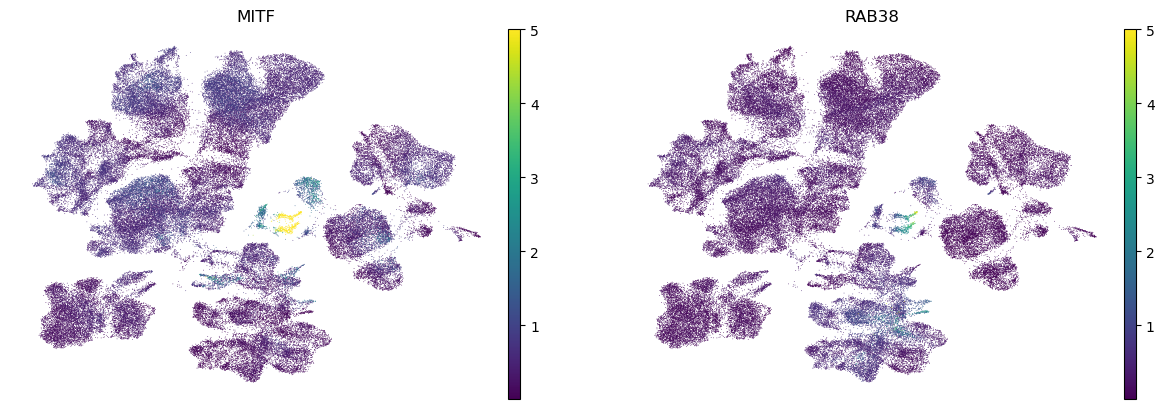

In [87]:
sc.pl.umap(adata_integrate_raw, color = ['MITF','RAB38'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Melanocytes 12


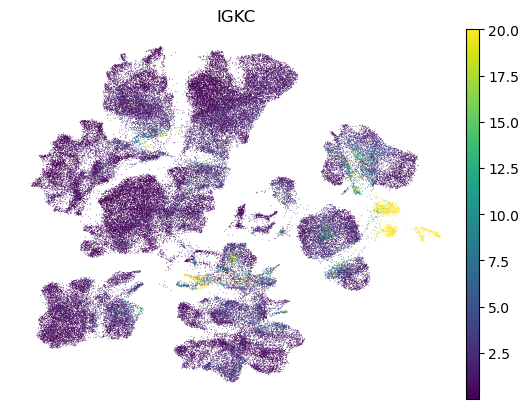

In [117]:
sc.pl.umap(adata_integrate_raw, color = ['IGKC'], frameon = False, layer = 'scvi_normalized', vmax = 20) #erythroid-like 10


In [122]:
cell_type = {"0":"Fibroblast",
"1":"SMC",
"2":"Basalkera",
"3":"VasEpithelial",
"4":"Fibroblast",
"5":"SMC",
"6":"Macrophage",
"7":"Tcell",
"8":"Basalkera",
"9":"Tcell",
"10":"Erythroid-like",
"11":"Mastcell",
"12":"Melanocytes",
}

In [123]:
adata_integrate_raw.obs['cell type'] = adata_integrate_raw.obs.leiden.map(cell_type)


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


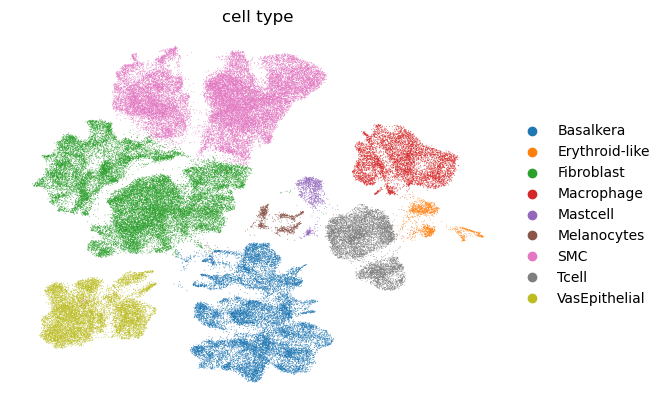

In [125]:
sc.pl.umap(adata_integrate_raw, color = ['cell type'], frameon = False)


In [126]:
adata_integrate_raw

AnnData object with n_obs × n_vars = 92424 × 11876
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [127]:
adata_integrate_raw.obs.Sample.unique().tolist()


['Healthy', 'DFU- healer', 'DFU-non healer', 'Diabetic']

# Counting cell

In [133]:
def map_condition(x):
    if 'Healthy' in x:
        return 'Healthy'
    elif 'Diabetic' in x:
        return 'Diabetic'
    elif 'DFU- healer' in x:
        return 'DFU- healer'
    else:
        return 'DFU-non healer'

In [143]:
adata_integrate_raw.obs['condition'] = adata_integrate_raw.obs.Sample.map(map_condition)
print(adata_integrate_raw.obs)

                      Sample  doublet  n_genes  n_genes_by_counts  \
AAACCCAAGGTCGAGT-1   Healthy    False     7618               7618   
AAACCCATCCCATTTA-1   Healthy    False     4428               4428   
AAACGAAAGCATCCTA-1   Healthy    False      749                749   
AAACGAATCGATGCAT-1   Healthy    False     2549               2549   
AAAGGATAGCTTCATG-1   Healthy    False     3853               3853   
...                      ...      ...      ...                ...   
TTTGCGCTCCTAGTGA    Diabetic    False     1006               1006   
TTTGGTTAGGGCTTGA    Diabetic    False     1329               1329   
TTTGGTTGTGAGTGAC    Diabetic    False      709                709   
TTTGTCAAGATGTCGG    Diabetic    False     1537               1537   
TTTGTCATCTTCGAGA    Diabetic    False     1790               1790   

                    total_counts  total_counts_mt  pct_counts_mt  \
AAACCCAAGGTCGAGT-1       57996.0              0.0            0.0   
AAACCCATCCCATTTA-1       16590.0   

In [144]:
num_tot_cells = adata_integrate_raw.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/tmp/ipykernel_673250/2471726013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata_integrate_raw.obs.groupby(['Sample']).count()


{'DFU- healer': 27793,
 'DFU-non healer': 16804,
 'Diabetic': 12465,
 'Healthy': 35362}

In [152]:
cell_type_counts = adata_integrate_raw.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
#cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
print(cell_type_counts)

            Sample       condition       cell type  doublet  n_genes  \
0      DFU- healer     DFU- healer       Basalkera     3236     3236   
1      DFU- healer     DFU- healer  Erythroid-like      451      451   
2      DFU- healer     DFU- healer      Fibroblast     8496     8496   
3      DFU- healer     DFU- healer      Macrophage     2619     2619   
4      DFU- healer     DFU- healer        Mastcell       86       86   
5      DFU- healer     DFU- healer     Melanocytes       10       10   
6      DFU- healer     DFU- healer             SMC     7849     7849   
7      DFU- healer     DFU- healer           Tcell     2427     2427   
8      DFU- healer     DFU- healer   VasEpithelial     2619     2619   
9   DFU-non healer  DFU-non healer       Basalkera     2640     2640   
10  DFU-non healer  DFU-non healer  Erythroid-like      537      537   
11  DFU-non healer  DFU-non healer      Fibroblast     3557     3557   
12  DFU-non healer  DFU-non healer      Macrophage     1907     

/tmp/ipykernel_673250/672114786.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_integrate_raw.obs.groupby(['Sample', 'condition', 'cell type']).count()


In [149]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

Sample       condition       cell type  doublet  n_genes  \
0      DFU- healer     DFU- healer       Basalkera     3236     3236   
1      DFU- healer     DFU- healer  Erythroid-like      451      451   
2      DFU- healer     DFU- healer      Fibroblast     8496     8496   
3      DFU- healer     DFU- healer      Macrophage     2619     2619   
4      DFU- healer     DFU- healer        Mastcell       86       86   
5      DFU- healer     DFU- healer     Melanocytes       10       10   
6      DFU- healer     DFU- healer             SMC     7849     7849   
7      DFU- healer     DFU- healer           Tcell     2427     2427   
8      DFU- healer     DFU- healer   VasEpithelial     2619     2619   
9   DFU-non healer  DFU-non healer       Basalkera     2640     2640   
10  DFU-non healer  DFU-non healer  Erythroid-like      537      537   
11  DFU-non healer  DFU-non healer      Fibroblast     3557     3557   
12  DFU-non healer  DFU-non healer      Macrophage     1907     1907   
13  DFU-non healer  DFU-non healer        Mastcell      130      130   
14  DFU-non healer  DFU-non healer     Melanocytes      246      246   
15  DFU-non healer  DFU-non healer             SMC     4009     4009   
16  DFU-non healer  DFU-non healer           Tcell     1954     1954   
17  DFU-non healer  DFU-non healer   VasEpithelial     1824     1824   
18        Diabetic        Diabetic       Basalkera     2173     2173   
19        Diabetic        Diabetic  Erythroid-like       12       12   
20        Diabetic        Diabetic      Fibroblast     4010     4010   
21        Diabetic        Diabetic      Macrophage      630      630   
22        Diabetic        Diabetic        Mastcell       72       72   
23        Diabetic        Diabetic     Melanocytes      101      101   
24        Diabetic        Diabetic             SMC     2750     2750   
25        Diabetic        Diabetic           Tcell      737      737   
26        Diabetic        Diabetic   VasEpithelial     1980     1980   
27         Healthy         Healthy       Basalkera     8003     8003   
28         Healthy         Healthy  Erythroid-like      245      245   
29         Healthy         Healthy      Fibroblast     9783     9783   
30         Healthy         Healthy      Macrophage     1278     1278   
31         Healthy         Healthy        Mastcell      692      692   
32         Healthy         Healthy     Melanocytes      586      586   
33         Healthy         Healthy             SMC     9249     9249   
34         Healthy         Healthy           Tcell     1740     1740   
35         Healthy         Healthy   VasEpithelial     3786     3786   

    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                3236          3236             3236           3236   
1                 451           451              451            451   
2                8496          8496             8496           8496   
3                2619          2619             2619           2619   
4                  86            86               86             86   
5                  10            10               10             10   
6                7849          7849             7849           7849   
7                2427          2427             2427           2427   
8                2619          2619             2619           2619   
9                2640          2640             2640           2640   
10                537           537              537            537   
11               3557          3557             3557           3557   
12               1907          1907             1907           1907   
13                130           130              130            130   
14                246           246              246            246   
15               4009          4009             4009           4009   
16               1954          1954             1954           1954   
17               1824          1824             1824           1824  

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


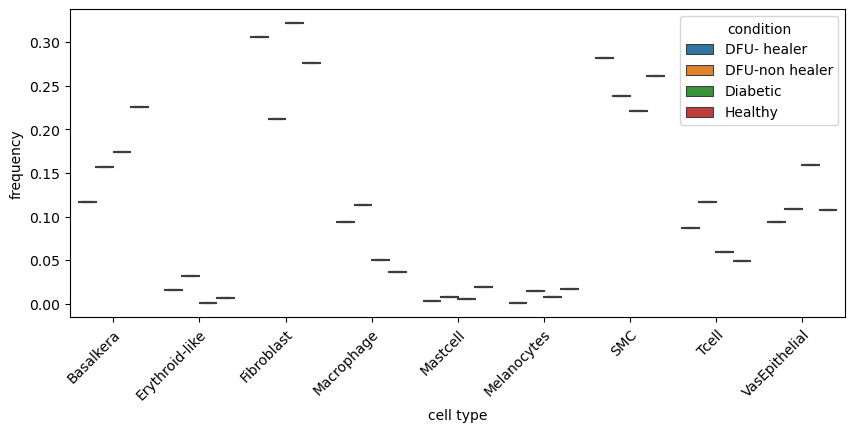

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right')

plt.show()

#DE analysis

In [164]:
subset = adata_integrate_raw[adata_integrate_raw.obs['cell type'].isin(['Macrophage'])].copy()


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [159]:
!pip install diffxpy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 20.9 MB/s eta 0:00:00
  Obtaining dependency information for dask from https://files.pythonhosted.org/packages/3d/2f/f08c8fdc77fafcd15c14dd80b891600184b35ad60784461ddc9fea44a549/dask-2023.9.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00


In [160]:
import diffxpy.api as de


In [165]:
subset.X = subset.X.toarray()


In [166]:
len(subset.var)


11876

In [167]:
subset

AnnData object with n_obs × n_vars = 6434 × 11876
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [168]:
sc.pp.filter_genes(subset, min_cells=100)

In [169]:
len(subset.var)


9804

In [170]:
subset.obs = subset.obs.rename(columns = {'cell type':'cell_type'})


In [171]:
subset.obs


Sample  doublet  n_genes  n_genes_by_counts  \
AACAGGGCACAAGCCC-1   Healthy    False     2356               2356   
AAGTGAATCTATGCCC-1   Healthy    False     1483               1483   
ACAAGCTCATCTCCCA-1   Healthy    False     3342               3342   
ACATGCAAGTGGGAAA-1   Healthy    False     4973               4973   
ACCTACCCATTCACAG-1   Healthy    False     3463               3463   
...                      ...      ...      ...                ...   
TCACAAGGTACAGTTC    Diabetic    False      746                746   
TCAGGTATCATCGGAT    Diabetic    False      520                520   
TCGCGAGAGTTACCCA    Diabetic    False      476                476   
TCTCTAAGTCGCGTGT    Diabetic    False     1063               1063   
TGCACCTTCTGGTGTA    Diabetic    False      589                589   

                    total_counts  total_counts_mt  pct_counts_mt  \
AACAGGGCACAAGCCC-1        6845.0              0.0            0.0   
AAGTGAATCTATGCCC-1        4270.0              0.0            0.0   
ACAAGCTCATCTCCCA-1       16915.0              0.0            0.0   
ACATGCAAGTGGGAAA-1       41959.0              0.0            0.0   
ACCTACCCATTCACAG-1       21414.0              0.0            0.0   
...                          ...              ...            ...   
TCACAAGGTACAGTTC          1473.0              0.0            0.0   
TCAGGTATCATCGGAT           956.0              0.0            0.0   
TCGCGAGAGTTACCCA           968.0              0.0            0.0   
TCTCTAAGTCGCGTGT          2468.0              0.0            0.0   
TGCACCTTCTGGTGTA          1223.0              0.0            0.0   

                    total_counts_ribo  pct_counts_ribo  _scvi_batch  \
AACAGGGCACAAGCCC-1              668.0         9.758947            0   
AAGTGAATCTATGCCC-1              197.0         4.613583            0   
ACAAGCTCATCTCCCA-1             3651.0        21.584393            0   
ACATGCAAGTGGGAAA-1             8870.0        21.139685            0   
ACCTACCCATTCACAG-1             4979.0        23.251144            0   
...                               ...              ...          ...   
TCACAAGGTACAGTTC                327.0        22.199593            0   
TCAGGTATCATCGGAT                104.0        10.878661            0   
TCGCGAGAGTTACCCA                128.0        13.223140            0   
TCTCTAAGTCGCGTGT                327.0        13.249596            0   
TGCACCTTCTGGTGTA                229.0        18.724447            0   

                    _scvi_labels leiden  _scvi_raw_norm_scaling   cell_type  \
AACAGGGCACAAGCCC-1             0      6                1.526951  Macrophage   
AAGTGAATCTATGCCC-1             0      6                2.423655  Macrophage   
ACAAGCTCATCTCCCA-1             0      6                0.612482  Macrophage   
ACATGCAAGTGGGAAA-1             0      6                0.244930  Macrophage   
ACCTACCCATTCACAG-1             0      6                0.480538  Macrophage   
...                          ...    ...                     ...         ...   
TCACAAGGTACAGTTC               0      6                7.092198  Macrophage   
TCAGGTATCATCGGAT               0      6               10.764262  Macrophage   
TCGCGAGAGTTACCCA               0      6               10.752688  Macrophage   
TCTCTAAGTCGCGTGT               0      6                4.340278  Macrophage   
TGCACCTTCTGGTGTA               0      6                8.396305  Macrophage   

                   condition  
AACAGGGCACAAGCCC-1   Healthy  
AAGTGAATCTATGCCC-1   Healthy  
ACAAGCTCATCTCCCA-1   Healthy  
ACATGCAAGTGGGAAA-1   Healthy  
ACCTACCCATTCACAG-1   Healthy  
...                      ...  
TCACAAGGTACAGTTC    Diabetic  
TCAGGTATCATCGGAT    Diabetic  
TCGCGAGAGTTACCCA    Diabetic  
TCTCTAAGTCGCGTGT    Diabetic  
TGCACCTTCTGGTGTA    Diabetic  

[6434 rows x 15 columns]